<a href="https://colab.research.google.com/github/bforoura/IDS/blob/main/decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supervised Learning: Decision Tree Classification**
* The CART algorithm (Gini Index)
* The C5.0 algorithm (Entropy)

In [1]:
import pandas as pd
import numpy as np

In [2]:
# The adult_training dataset has several numeric and categoric predictors about adults, their
# occupation, marital status, economic status, financial status, etc.

adultDF= pd.read_csv("https://raw.githubusercontent.com/bforoura/IDS/main/HW4/adult_training.csv")

In [3]:
# We will use Income as the target class in this exercise

adultDF.head()


,age,workclass,education,marital-status,occupation,sex,capital-gain,capital-loss,income
0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,0,0,<=50K
1,38,Private,9,Divorced,Handlers-cleaners,Male,0,0,<=50K
2,49,Private,5,Married-spouse-absent,Other-service,Female,0,0,<=50K
3,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Male,0,0,>50K
4,31,Private,14,Never-married,Prof-specialty,Female,14084,0,>50K


## **Training Data Preparation for Classification**


* For simplicity, only two predictors and the target are retained, as follows:

> * **Marital status**: a categorical predictor with classes married, divorced, never‐married, separated, and widowed.
> * **Cap_gains_losses**: a numerical predictor, equal to **capital gains + |capital losses|**.
> * **Income**: a categorical target variable with two classes >50k and ≤50k

In [25]:
# Create a new predictor
adultDF['capital-gains-losses'] = adultDF['capital-gain'] + abs(adultDF['capital-loss'])


# Create a new dataframe for the classification task with only three columns: two predictors and a target
new_adultDF = adultDF

new_adultDF.head(10)


,age,workclass,education,marital-status,occupation,sex,capital-gain,capital-loss,income,capital-gains-losses
0,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Male,0,0,<=50K,0
1,38,Private,9,Divorced,Handlers-cleaners,Male,0,0,<=50K,0
2,49,Private,5,Married-spouse-absent,Other-service,Female,0,0,<=50K,0
3,52,Self-emp-not-inc,9,Married-civ-spouse,Exec-managerial,Male,0,0,>50K,0
4,31,Private,14,Never-married,Prof-specialty,Female,14084,0,>50K,14084
5,40,Private,11,Married-civ-spouse,Craft-repair,Male,0,0,>50K,0
6,38,Private,7,Married-civ-spouse,Sales,Male,0,0,<=50K,0
7,43,Private,7,Married-civ-spouse,Transport-moving,Male,0,2042,<=50K,2042
8,54,?,10,Married-civ-spouse,?,Male,0,0,>50K,0
9,39,Private,9,Divorced,Exec-managerial,Male,0,0,<=50K,0


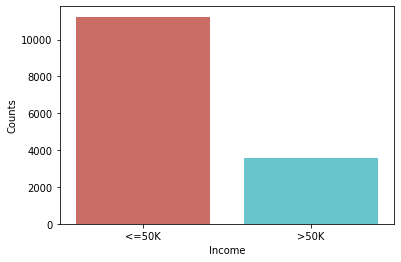

In [26]:
# Examine target class distrbutions

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='income', data=new_adultDF, palette = 'hls')
plt.xlabel('Income')
plt.ylabel('Counts')
plt.show()



In [27]:
# We now need to encode the categoric columns

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# save the encoded dataframe here
encoded_adultDF = pd.DataFrame()

# Encode  only the categoric or boolean attributes (if any)
for i in range(0, new_adultDF.shape[1]):
    if new_adultDF.dtypes[i]=='object' or new_adultDF.dtypes[i]=='bool':
        encoded_adultDF[new_adultDF.columns[i]] = le.fit_transform(new_adultDF[new_adultDF.columns[i]])
    else:
        encoded_adultDF[new_adultDF.columns[i]] = new_adultDF[new_adultDF.columns[i]]
        
encoded_adultDF.head(10)


,age,workclass,education,marital-status,occupation,sex,capital-gain,capital-loss,income,capital-gains-losses
0,50,6,13,2,4,1,0,0,0,0
1,38,4,9,0,6,1,0,0,0,0
2,49,4,5,3,8,0,0,0,0,0
3,52,6,9,2,4,1,0,0,1,0
4,31,4,14,4,10,0,14084,0,1,14084
5,40,4,11,2,3,1,0,0,1,0
6,38,4,7,2,12,1,0,0,0,0
7,43,4,7,2,14,1,0,2042,0,2042
8,54,0,10,2,0,1,0,0,1,0
9,39,4,9,0,4,1,0,0,0,0


## **Train_Test_Split**

In [28]:
from sklearn.model_selection import train_test_split

# Prepare X and y
X = encoded_adultDF.drop(['income'], axis=1)
y = encoded_adultDF['income']


# Let's do an 80-20 split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, random_state=42, shuffle=True, train_size=0.80, stratify=y)



In [29]:
print("Training size:", X_train.shape)
print("Test size:", X_test.shape)


Training size: (11837, 9)
Test size: (2960, 9)


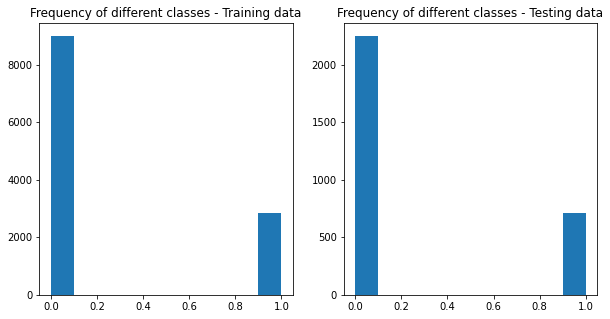

In [30]:
# Find out class distributions in training and test datasets.

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(y_train);
plt.title('Frequency of different classes - Training data');

plt.subplot(1,2,2)
plt.hist(y_test);
plt.title('Frequency of different classes - Testing data');




## **Training, Plotting, and Printing Decision Trees**

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


### **The Decision Tree Classifier**

In [100]:
def MakeDTModel(Xtrain, Ytrain, split_type, max_leaf_nodes=5, max_depth=None):
    cart_classifier = DecisionTreeClassifier(criterion = split_type, 
                                         max_leaf_nodes=5,
                                         max_depth = None,
                                         random_state = 120).fit(Xtrain, Ytrain)
    return cart_classifier

In [101]:
from matplotlib.pyplot import figure

def displayTree(classifier, X):
    # Control the figure size
    figure(figsize=(10, 8), dpi=80)
    
    
    # Plot the tree
    cn = ['low_income', 'hi_income']
    tree.plot_tree(classifier, feature_names=X.columns.values.tolist(), 
                                    class_names=cn,
                                    filled = True)
    
    
    # Print the text version of the tree
    text_representation = tree.export_text(classifier, 
                                           feature_names=X.columns.values.tolist())
    
    print(text_representation)
    
    return 

### **The CART Classifier**

|--- capital-gains-losses <= 5095.50
|   |--- marital-status <= 2.50
|   |   |--- education <= 12.50
|   |   |   |--- marital-status <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- marital-status >  0.50
|   |   |   |   |--- class: 0
|   |   |--- education >  12.50
|   |   |   |--- class: 1
|   |--- marital-status >  2.50
|   |   |--- class: 0
|--- capital-gains-losses >  5095.50
|   |--- class: 1



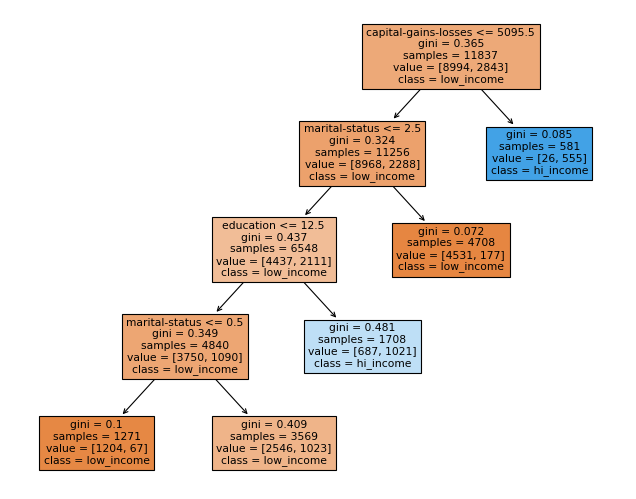

In [102]:
# passing split_type as gini to make an Cart_classifier

cart_classifier = MakeDTModel(X_train, y_train, 'gini', max_leaf_nodes=5, max_depth=None)
displayTree(cart_classifier, X)

### **The C5.0 Classifier**

|--- marital-status <= 2.50
|   |--- education <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education >  12.50
|   |   |--- class: 1
|--- marital-status >  2.50
|   |--- capital-gains-losses <= 4718.50
|   |   |--- class: 0
|   |--- capital-gains-losses >  4718.50
|   |   |--- class: 1



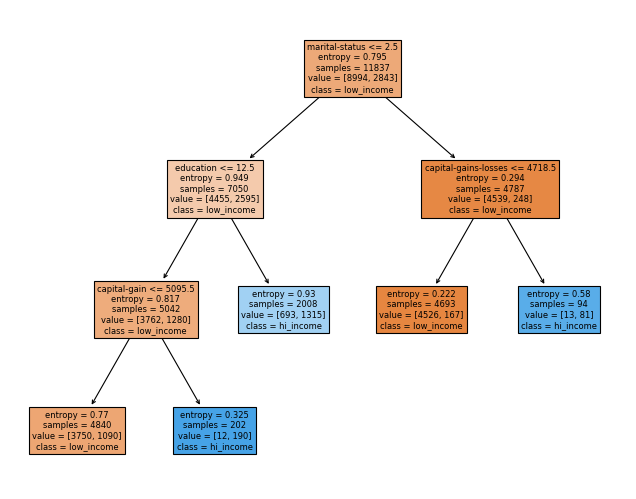

In [103]:
c5_classifier = MakeDTModel(X_train, y_train, 'entropy', max_leaf_nodes=5, max_depth=None)
displayTree(c5_classifier, X)

## **Accuracy Scores on the Training and Test Datasets**

In [104]:
# Record CART's classification accuracy on tarining and test datasets
score1 = round(cart_classifier.score(X_train, y_train), 2) # training score
score2 = round(cart_classifier.score(X_test, y_test), 2)   # testing score

print ("CART Training and Testing scores: %.2f, %.2f" %  (score1, score2))


# Record C5's classification accuracy on tarining and test datasets
score3 = round(c5_classifier.score(X_train, y_train), 2) # training score
score4 = round(c5_classifier.score(X_test, y_test), 2)   # testing score

print ("C5.0 Training and Testing scores: %.2f, %.2f" %  (score3, score4))

CART Training and Testing scores: 0.83, 0.82
C5.0 Training and Testing scores: 0.83, 0.82


## **The Confusion Matrix**

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def displayCM(classifier, Xtrain, Xtest, Ytrain, Ytest ):

    if classifier.criterion == 'gini':

        # Record CART's predictions
        cart_predictions = classifier.predict(Xtest)

         # Compute TP, TN, FP, FN values for CART
        cart_cm = confusion_matrix(y_true=Ytest, 
                                   y_pred = cart_predictions)

        # Print CART's confusion matrix
        print("CART_Confusion_Matrix")
        print()
        print(cart_cm)

        print('-'*80)

        # Visualize CART's confusion matrix as a heatmap
        print("HEATMAP_CART_Confusion_Matrix")
        plt.figure(figsize=(8,8))
        sns.heatmap(cart_cm, annot=True, 
                    linewidths=.5, square = True, cmap = 'Oranges_r', fmt='0.4g');

        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')


    if classifier.criterion == 'entropy':
        
        # Record C5's predictions
        c5_predictions = classifier.predict(Xtest)
    
        # Compute TP, TN, FP, FN values for CART
        c5_cm = confusion_matrix(y_true=Ytest, 
                                y_pred = c5_predictions)
        
        # Print C5's confusion matrix
        print("C5_Confusion_Matrix")
        print()
        print(c5_cm)

        print('-'*80)

        # Visualize C5's confusion matrix as a heatmap
        print("HEATMAP_C5_Confusion_Matrix")
        plt.figure(figsize=(8,8))
        sns.heatmap(c5_cm, annot=True, 
                    linewidths=.5, square = True, cmap = 'Oranges_r', fmt='0.4g');
        
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')


CART_Confusion_Matrix

[[2083  166]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_CART_Confusion_Matrix


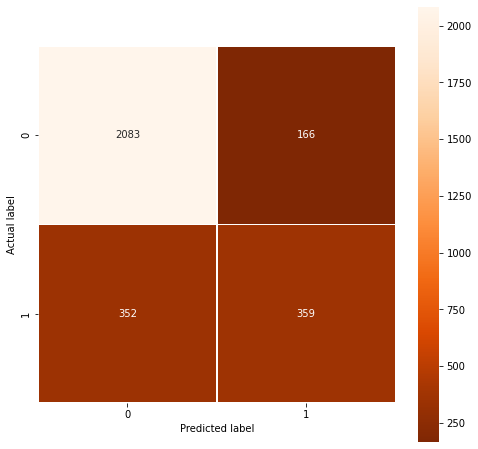

In [106]:
displayCM(cart_classifier, X_train, X_test, y_train, y_test )

C5_Confusion_Matrix

[[2080  169]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_C5_Confusion_Matrix


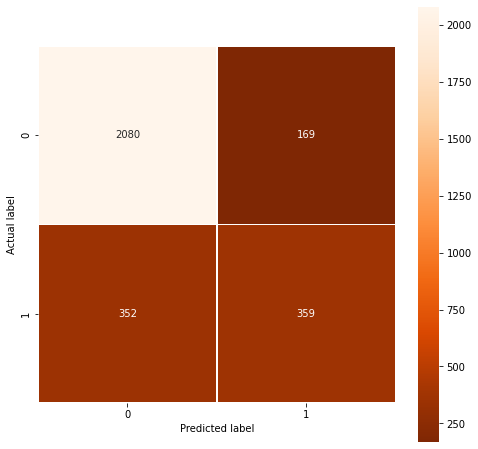

In [107]:
displayCM(c5_classifier, X_train, X_test, y_train, y_test )

## **Summary**

* Side-by-side comparison of the 2 models demonstrates that both CART and C5.0 produce similar classification accuracy on the dataset.
* As an exercise, it will be worthwhile to further study the effect of the train-test split on the classification accuracy.
* V-fold cross validation will provide more reliable estimates of the two models' classification accuracy.

In [109]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

def compareModels(classifier1, classifier2):

    # Record CART's classification accuracy on tarining and test datasets
    score1 = round(classifier1.score(X_train, y_train), 2) # training score
    score2 = round(classifier1.score(X_test, y_test), 2)   # testing score

    print ("CART Training and Testing scores: %.2f, %.2f" %  (score1, score2))
    
    # Record C5's classification accuracy on tarining and test datasets
    score3 = round(classifier2.score(X_train, y_train), 2) # training score
    score4 = round(classifier2.score(X_test, y_test), 2)   # testing score

    print ("C5.0 Training and Testing scores: %.2f, %.2f" %  (score3, score4))
    
    labels = ['CART', 'C5.0']
    training_scores = [score1, score3]
    testing_scores =  [score2, score4]

    x = np.arange(2)  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, training_scores, width, label='Training', color='navy')
    rects2 = ax.bar(x + width/2, testing_scores, width, label='Testing', color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Model Accuracy')
    ax.set_xticks(x)
    ax.set_ylim(0,1)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor = (1.3, 1.0), loc='upper right')

    plt.title('Model Comparisons')
    plt.show()

CART Training and Testing scores: 0.83, 0.82
C5.0 Training and Testing scores: 0.83, 0.82


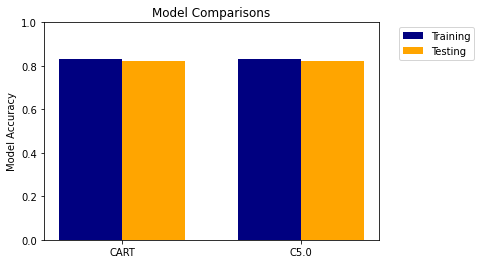

In [110]:
compareModels(cart_classifier, c5_classifier)

# Hypertuning max_depth and max_leaf_nodes

# max_depth = 2 ; max_leaf_nodes = 3 

|--- capital-gains-losses <= 5095.50
|   |--- marital-status <= 2.50
|   |   |--- education <= 12.50
|   |   |   |--- marital-status <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- marital-status >  0.50
|   |   |   |   |--- class: 0
|   |   |--- education >  12.50
|   |   |   |--- class: 1
|   |--- marital-status >  2.50
|   |   |--- class: 0
|--- capital-gains-losses >  5095.50
|   |--- class: 1



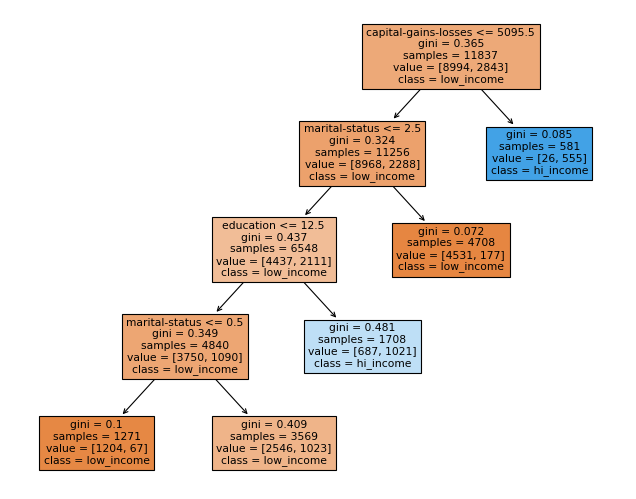

In [75]:
cart_classifier = MakeDTModel(X_train, y_train, 'gini', max_leaf_nodes=3, max_depth=2)
displayTree(cart_classifier, X)

|--- marital-status <= 2.50
|   |--- education <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education >  12.50
|   |   |--- class: 1
|--- marital-status >  2.50
|   |--- capital-gains-losses <= 4718.50
|   |   |--- class: 0
|   |--- capital-gains-losses >  4718.50
|   |   |--- class: 1



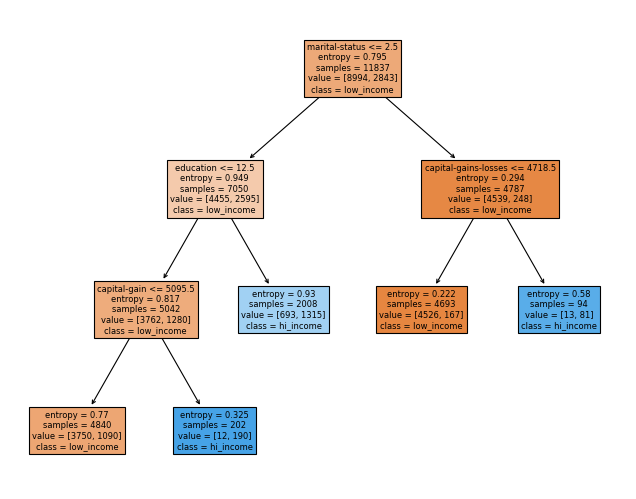

In [76]:
c5_classifier = MakeDTModel(X_train, y_train, 'entropy', max_leaf_nodes=3, max_depth=2)
displayTree(c5_classifier, X)

CART_Confusion_Matrix

[[2083  166]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_CART_Confusion_Matrix


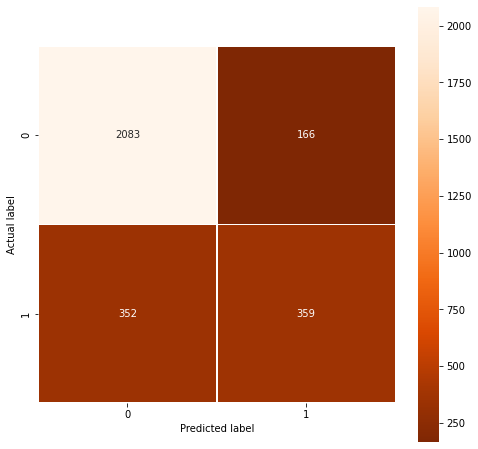

In [77]:
displayCM(cart_classifier, X_train, X_test, y_train, y_test )

C5_Confusion_Matrix

[[2080  169]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_C5_Confusion_Matrix


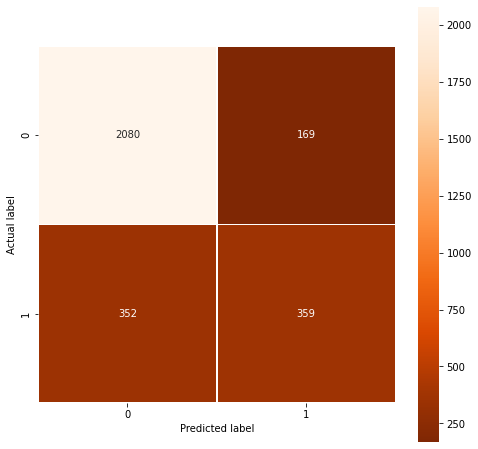

In [78]:
displayCM(c5_classifier, X_train, X_test, y_train, y_test )

CART Training and Testing scores: 0.83, 0.82
C5.0 Training and Testing scores: 0.83, 0.82


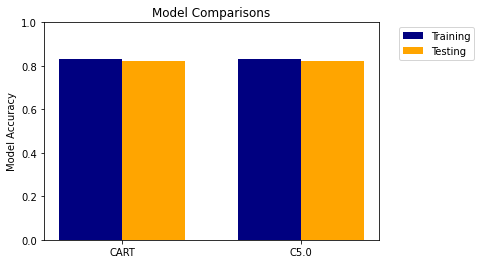

In [79]:
compareModels(cart_classifier, c5_classifier)

# max_depth = 3 ; max_leaf_nodes = 4 

|--- capital-gains-losses <= 5095.50
|   |--- marital-status <= 2.50
|   |   |--- education <= 12.50
|   |   |   |--- marital-status <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- marital-status >  0.50
|   |   |   |   |--- class: 0
|   |   |--- education >  12.50
|   |   |   |--- class: 1
|   |--- marital-status >  2.50
|   |   |--- class: 0
|--- capital-gains-losses >  5095.50
|   |--- class: 1



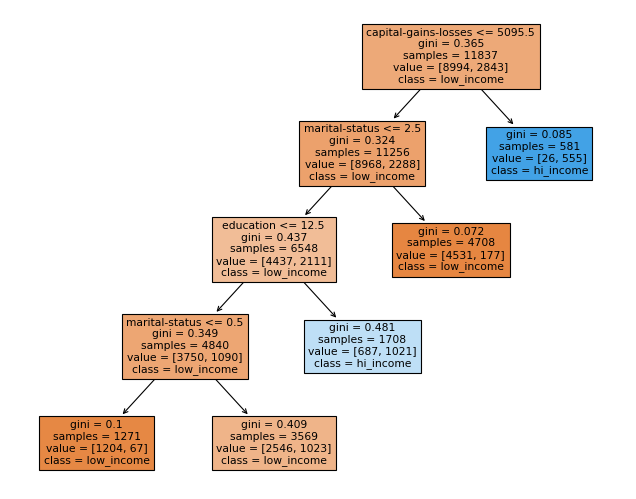

In [80]:
cart_classifier = MakeDTModel(X_train, y_train, 'gini', max_leaf_nodes=4, max_depth=3)
displayTree(cart_classifier, X)

|--- marital-status <= 2.50
|   |--- education <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education >  12.50
|   |   |--- class: 1
|--- marital-status >  2.50
|   |--- capital-gains-losses <= 4718.50
|   |   |--- class: 0
|   |--- capital-gains-losses >  4718.50
|   |   |--- class: 1



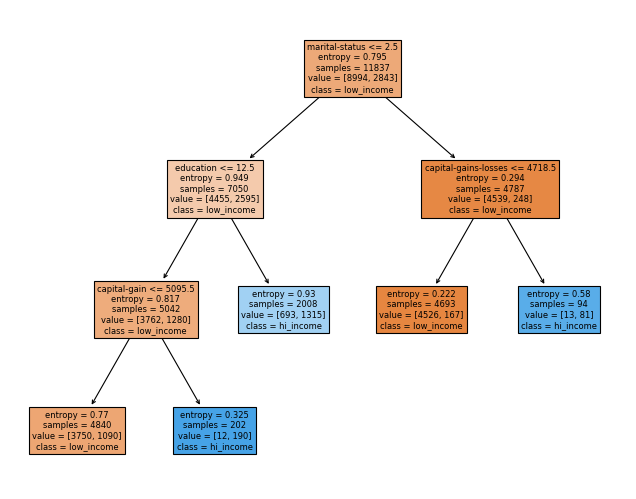

In [81]:
c5_classifier = MakeDTModel(X_train, y_train, 'entropy', max_leaf_nodes=4, max_depth=3)
displayTree(c5_classifier, X)

CART_Confusion_Matrix

[[2083  166]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_CART_Confusion_Matrix


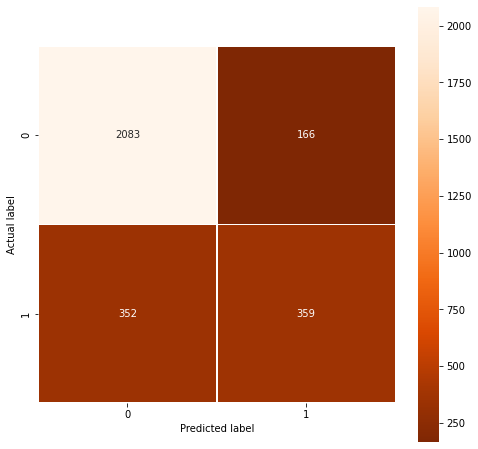

In [82]:
displayCM(cart_classifier, X_train, X_test, y_train, y_test )

C5_Confusion_Matrix

[[2080  169]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_C5_Confusion_Matrix


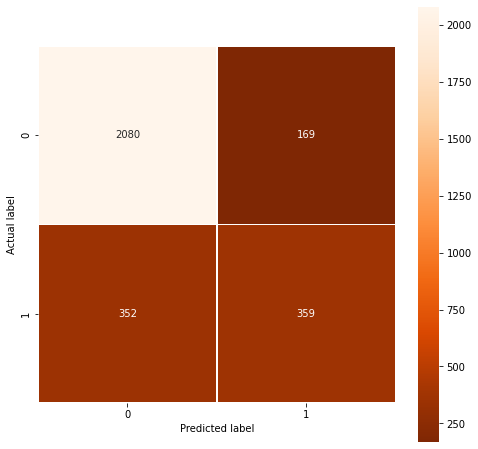

In [83]:
displayCM(c5_classifier, X_train, X_test, y_train, y_test )

CART Training and Testing scores: 0.83, 0.82
C5.0 Training and Testing scores: 0.83, 0.82


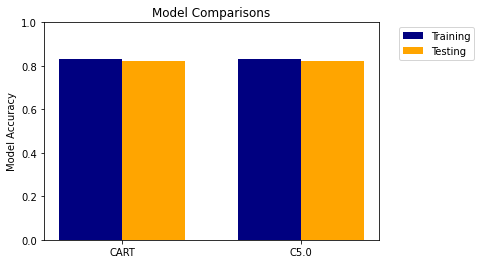

In [84]:
compareModels(cart_classifier, c5_classifier)

# max_depth = 5 ; max_leaf_nodes = 3

|--- capital-gains-losses <= 5095.50
|   |--- marital-status <= 2.50
|   |   |--- education <= 12.50
|   |   |   |--- marital-status <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- marital-status >  0.50
|   |   |   |   |--- class: 0
|   |   |--- education >  12.50
|   |   |   |--- class: 1
|   |--- marital-status >  2.50
|   |   |--- class: 0
|--- capital-gains-losses >  5095.50
|   |--- class: 1



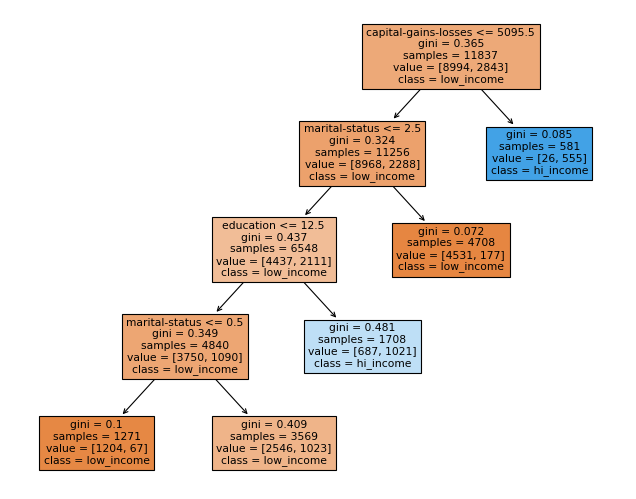

In [85]:
cart_classifier = MakeDTModel(X_train, y_train, 'gini', max_leaf_nodes=3, max_depth=5)
displayTree(cart_classifier, X)

|--- marital-status <= 2.50
|   |--- education <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education >  12.50
|   |   |--- class: 1
|--- marital-status >  2.50
|   |--- capital-gains-losses <= 4718.50
|   |   |--- class: 0
|   |--- capital-gains-losses >  4718.50
|   |   |--- class: 1



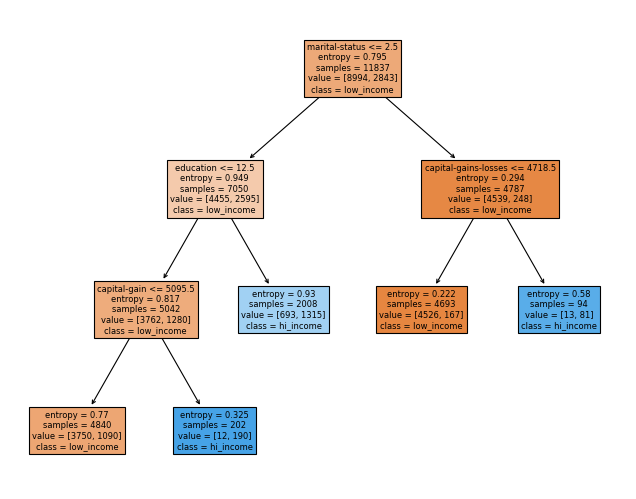

In [86]:
c5_classifier = MakeDTModel(X_train, y_train, 'entropy', max_leaf_nodes=3, max_depth=5)
displayTree(c5_classifier, X)

CART_Confusion_Matrix

[[2083  166]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_CART_Confusion_Matrix


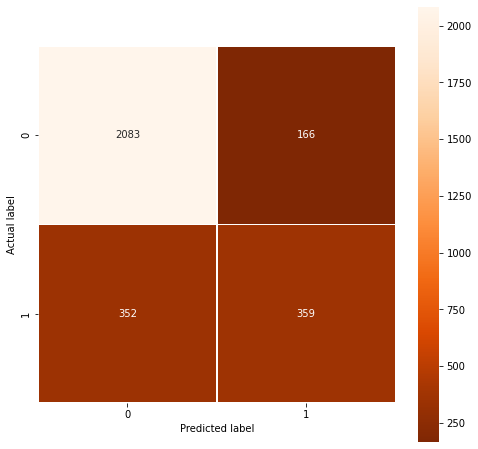

In [87]:
displayCM(cart_classifier, X_train, X_test, y_train, y_test )

C5_Confusion_Matrix

[[2080  169]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_C5_Confusion_Matrix


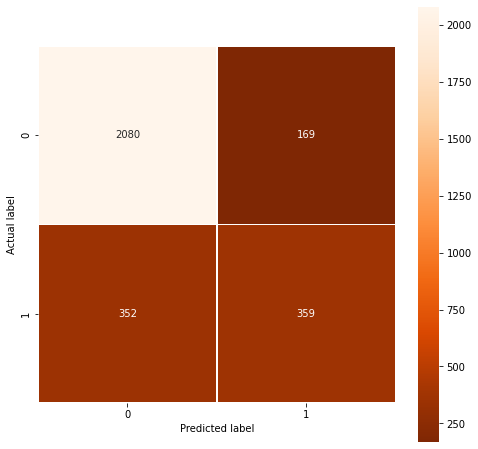

In [88]:
displayCM(c5_classifier, X_train, X_test, y_train, y_test )

CART Training and Testing scores: 0.83, 0.82
C5.0 Training and Testing scores: 0.83, 0.82


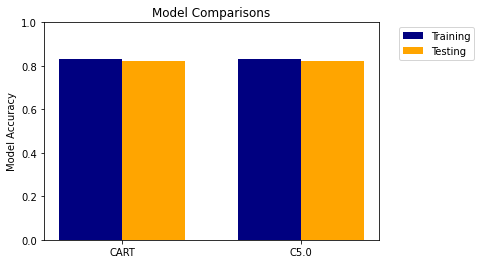

In [89]:
compareModels(cart_classifier, c5_classifier)

# max_depth = 5 ; max_leaf_nodes = 5 

|--- capital-gains-losses <= 5095.50
|   |--- marital-status <= 2.50
|   |   |--- education <= 12.50
|   |   |   |--- marital-status <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- marital-status >  0.50
|   |   |   |   |--- class: 0
|   |   |--- education >  12.50
|   |   |   |--- class: 1
|   |--- marital-status >  2.50
|   |   |--- class: 0
|--- capital-gains-losses >  5095.50
|   |--- class: 1



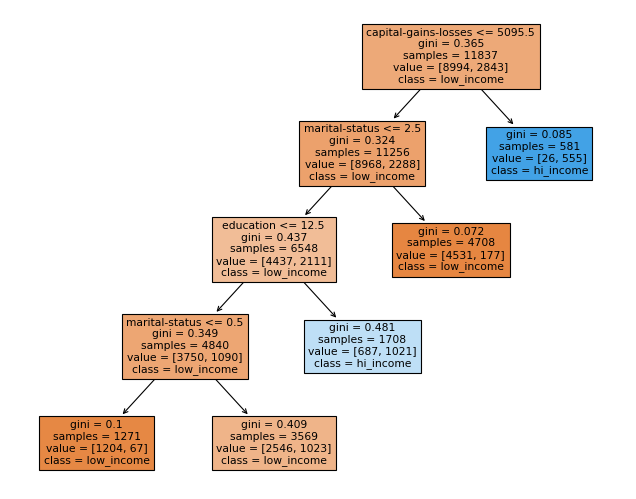

In [90]:
cart_classifier = MakeDTModel(X_train, y_train, 'gini', max_leaf_nodes=3, max_depth=2)
displayTree(cart_classifier, X)

|--- marital-status <= 2.50
|   |--- education <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education >  12.50
|   |   |--- class: 1
|--- marital-status >  2.50
|   |--- capital-gains-losses <= 4718.50
|   |   |--- class: 0
|   |--- capital-gains-losses >  4718.50
|   |   |--- class: 1



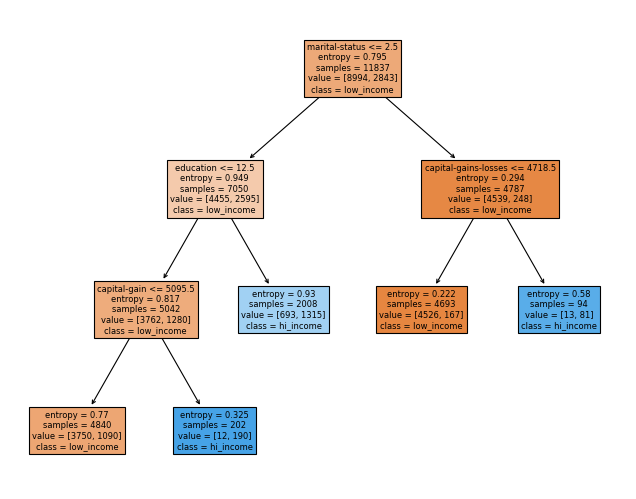

In [91]:
c5_classifier = MakeDTModel(X_train, y_train, 'entropy', max_leaf_nodes=3, max_depth=2)
displayTree(c5_classifier, X)

CART_Confusion_Matrix

[[2083  166]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_CART_Confusion_Matrix


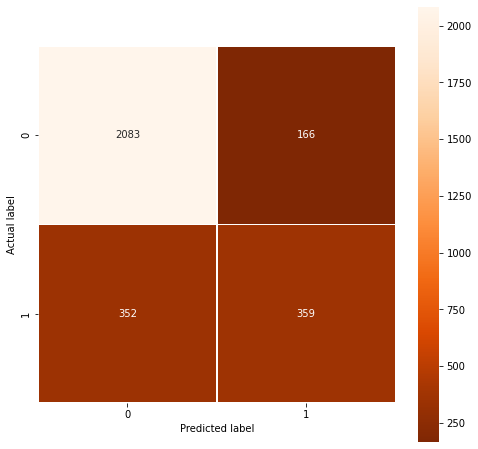

In [92]:
displayCM(cart_classifier, X_train, X_test, y_train, y_test )

C5_Confusion_Matrix

[[2080  169]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_C5_Confusion_Matrix


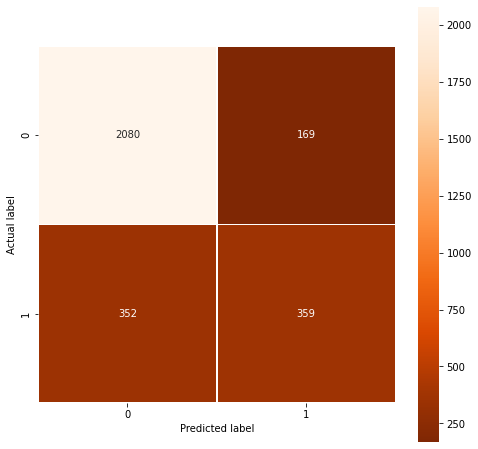

In [93]:
displayCM(c5_classifier, X_train, X_test, y_train, y_test )

CART Training and Testing scores: 0.83, 0.82
C5.0 Training and Testing scores: 0.83, 0.82


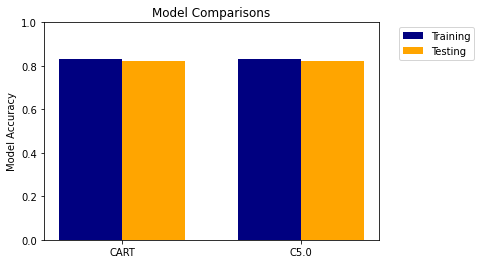

In [94]:
compareModels(cart_classifier, c5_classifier)

# max_depth = 2 ; max_leaf_nodes = 3 

|--- capital-gains-losses <= 5095.50
|   |--- marital-status <= 2.50
|   |   |--- education <= 12.50
|   |   |   |--- marital-status <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- marital-status >  0.50
|   |   |   |   |--- class: 0
|   |   |--- education >  12.50
|   |   |   |--- class: 1
|   |--- marital-status >  2.50
|   |   |--- class: 0
|--- capital-gains-losses >  5095.50
|   |--- class: 1



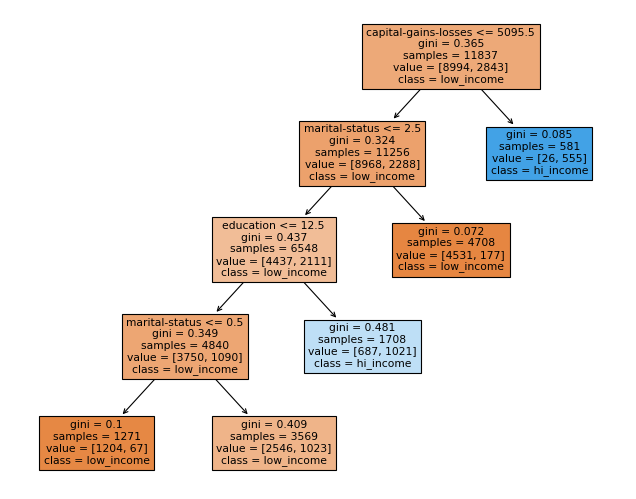

In [95]:
cart_classifier = MakeDTModel(X_train, y_train, 'gini', max_leaf_nodes=5, max_depth=5)
displayTree(cart_classifier, X)

|--- marital-status <= 2.50
|   |--- education <= 12.50
|   |   |--- capital-gain <= 5095.50
|   |   |   |--- class: 0
|   |   |--- capital-gain >  5095.50
|   |   |   |--- class: 1
|   |--- education >  12.50
|   |   |--- class: 1
|--- marital-status >  2.50
|   |--- capital-gains-losses <= 4718.50
|   |   |--- class: 0
|   |--- capital-gains-losses >  4718.50
|   |   |--- class: 1



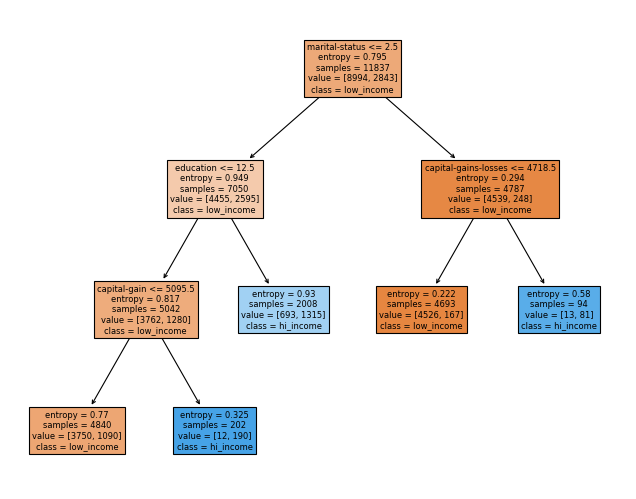

In [96]:
c5_classifier = MakeDTModel(X_train, y_train, 'entropy', max_leaf_nodes=5, max_depth=5)
displayTree(c5_classifier, X)

CART_Confusion_Matrix

[[2083  166]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_CART_Confusion_Matrix


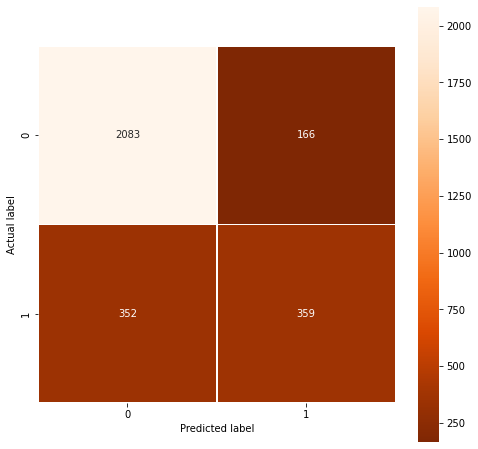

In [97]:
displayCM(cart_classifier, X_train, X_test, y_train, y_test )

C5_Confusion_Matrix

[[2080  169]
 [ 352  359]]
--------------------------------------------------------------------------------
HEATMAP_C5_Confusion_Matrix


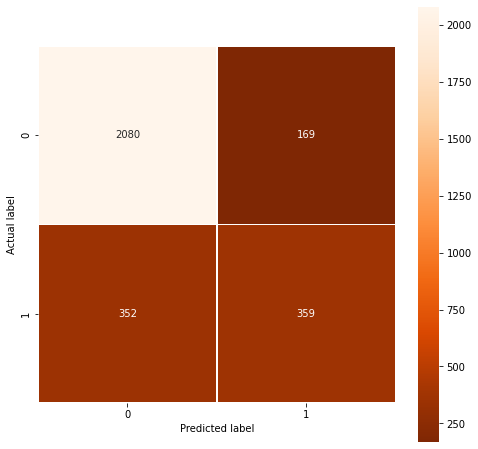

In [98]:
displayCM(c5_classifier, X_train, X_test, y_train, y_test )

CART Training and Testing scores: 0.83, 0.82
C5.0 Training and Testing scores: 0.83, 0.82


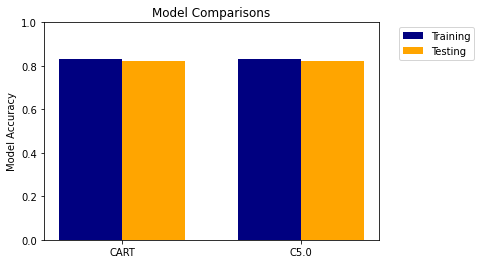

In [99]:
compareModels(cart_classifier, c5_classifier)

# Summary

* There is not very significant difference in change in accuracy values, but we can see that there is slight changes in confusion matrix. max_depth and max_leaf_nodes should be done using hypterparameter tuning. 